In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
import syndata
import align
import mgplvm
from mgplvm import kernels, rdist
from mgplvm.manifolds import Torus
from mgplvm.models import Core
from mgplvm.training import train
plt.rcParams.update({'font.size': 22})

In [2]:
torch.set_default_dtype(torch.float64)
device = mgplvm.utils.get_device("cuda")  # get_device("cpu")

d = 1  # dims of latent space
n = 50 # number of neurons
m = 200  # number of conditions / time points
n_z = 15  # number of inducing points
n_samples = 1  # number of samples
gen = syndata.Gen(syndata.Torus(d), n, m, variability=0.25, sigma = 0.2)

sig0 = 1.5
l = 0.5
gen.set_param('l', l)
Y = gen.gen_data()
print('mean activity:', np.mean(Y))
# specify manifold, kernel and rdist
manif = Torus(m, d)
ref_dist = mgplvm.rdist.MVN(m, d, sigma=sig0)
# initialize signal variance
alpha = np.mean(np.std(Y, axis=1), axis=1)
kernel = kernels.QuadExp(n, manif.distance, alpha=alpha)
# generate model
sigma = np.mean(np.std(Y, axis=1), axis=1)  # initialize noise
mod = Core(manif, n, m, n_z, kernel, ref_dist, sigma=sigma).to(device)

mean activity: 0.3719514019990583


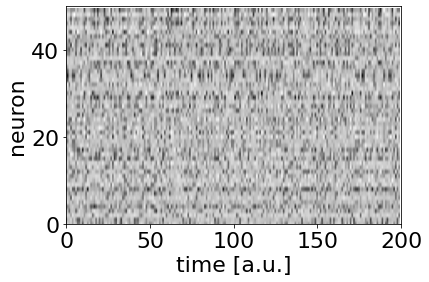

In [3]:
plt.figure()
Yplot = Y[:, :, 0]
plt.imshow(Yplot, cmap='Greys', aspect='auto')
plt.xlabel("time [a.u.]")
plt.ylabel("neuron")
plt.xlim(0,200)
plt.ylim(0,n)
plt.show()
plt.close()

In [4]:
# train model
trained_mod = train(Y,
                    mod,
                    device,
                    optimizer=optim.Adam,
                    outdir='none',
                    max_steps=1000,
                    burnin='default',
                    n_b=64,
                    lrate=5E-2,
                    print_every=50)

data = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)
mod = mod.to(device)
mulearn = mod.manif.prms.data.cpu()
mutrue = gen.gs[0]
plearn = mod.manif.distance(mulearn.T, mulearn.T).numpy()
ptrue = gen.manifold.manifs[0].distance(mutrue, mutrue)
ptrue, plearn = [p.flatten() for p in [ptrue, plearn]]

final importance weighted log likelihood: 0.0389


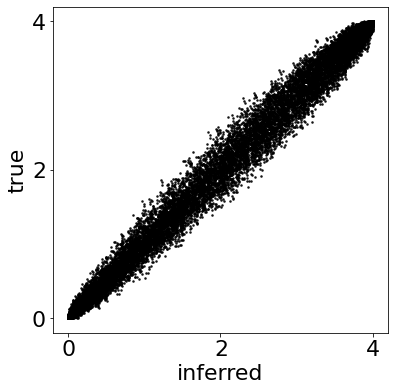

In [5]:
print('final importance weighted log likelihood: %.4f' % mod.calc_LL(data, 128).item())
plt.figure(figsize=(6, 6))
plt.plot(plearn, ptrue, "ko", markersize=1.5, alpha=0.5)
plt.xlabel("inferred")
plt.ylabel("true")
plt.xticks((0, 2, 4), ("$0$", "$2$", "$4$"))
plt.yticks((0, 2, 4), ("$0$", "$2$", "$4$"))
plt.show()
plt.close()

In [6]:
#align model to ground truth
mod = align.align_torus(mod, gen.gs[0])

# %% compute mse
query = mod.manif.mu.detach()
fmean, fstd = mod.predict(data, query, niter=100)
var = np.mean(np.var(Y, axis=1))
MSE = np.mean(((fmean - data)**2).cpu().numpy())
print('MSE:', MSE, 'var:', var)

coordinate system: [[-1]] 0 loss: 0.0057258277235105815
coordinate system: [[-1]] 1 loss: 0.005725827588654811
coordinate system: [[-1]] 2 loss: 0.005725827516100252
coordinate system: [[-1]] 3 loss: 0.005725827516133017
coordinate system: [[-1]] 4 loss: 0.0057258275161002434
coordinate system: [[1]] 0 loss: 1.9747619566874206
coordinate system: [[1]] 1 loss: 2.078275933915629
coordinate system: [[1]] 2 loss: 1.8852435288004843
coordinate system: [[1]] 3 loss: 1.8852435288004759
coordinate system: [[1]] 4 loss: 2.089442296456677
MSE: 0.04356995575351832 var: 0.1481920434941671


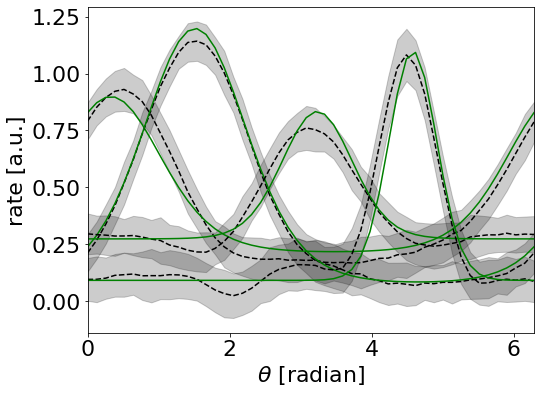

In [8]:
#%% consider 'tuning curves'
query = torch.tensor(np.linspace(0, 2 * np.pi, 50),
                     dtype=torch.get_default_dtype(),
                     device=device)

fmean, fstd = mod.predict(data, query, niter=100)
inds = [np.argmin((gen.gprefs[0] - val)**2) for val in 0.25 + np.arange(4) * 1.5]
plt.figure(figsize=(8, 6))

for i in inds:
    xs, m, std = [arr.cpu().numpy() for arr in [query, fmean, fstd]]
    m, std = [arr[i, :, 0] for arr in [m, std]]
    plt.plot(xs, m, "k--")
    plt.fill_between(xs, m - 2 * std, m + 2 * std, color='k', alpha=0.2)
    true_y = gen.gen_data(gs_in=[xs.reshape(-1, 1)], sigma=np.zeros((mod.n, 1)))
    plt.plot(xs, true_y[i, :, 0], 'g-')

plt.xlabel(r"$\theta$ [radian]")
plt.ylabel(r"rate [a.u.]")
plt.xlim(0, 2 * np.pi)
plt.show()
plt.close()